In [1]:
!pip install shap

# from google.colab import drive
# drive.mount('/content/drive')

# import os
# os.chdir("/content/drive/My Drive/ECEN758Project")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 8.3 MB/s eta 0:00:00
Mounted at /content/drive


In [2]:
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import f1_score
import torch
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pickle
import shap

# Reading Data

In [3]:
# Need to run 'feature_extraction' first to get the feature .pt file
feature_path = './Data/Features/vit_b_16_features.pt'
data = torch.load(feature_path)
for key, value in data.items():
    print(f'{key.capitalize()} Data (X, y): ', value[0].shape, value[1].shape)

Train Data (X, y):  (60000, 768) (60000,)
Test Data (X, y):  (10000, 768) (10000,)


# Data Splitting

In [4]:
X_train_original, X_val_original, y_train_original, y_val_original = train_test_split(
    data['train'][0], data['train'][1], test_size=5000, stratify=data['train'][1], random_state=10)
data['train'] = [X_train_original, y_train_original]
data['val'] = [X_val_original, y_val_original]
X_test_original, y_test_original = data['test'][0], data['test'][1]

for key, value in data.items():
    print(f'{key.capitalize()} Data (X, y): ', value[0].shape, value[1].shape)

Train Data (X, y):  (55000, 768) (55000,)
Test Data (X, y):  (10000, 768) (10000,)
Val Data (X, y):  (5000, 768) (5000,)


# Data Transformation

## PCA

In [5]:
pca = PCA()
scalar = StandardScaler().fit(data['train'][0])
X_train_scale = scalar.transform(X_train_original)
X_val_scale = scalar.transform(X_val_original)
X_test_scale = scalar.transform(X_test_original)

pca.fit(X_train_scale)
explained_variance_ratios = np.cumsum(pca.explained_variance_ratio_)

data['train'][0] = pca.transform(X_train_scale)
data['val'][0] = pca.transform(X_val_scale)
data['test'][0] = pca.transform(X_test_scale)

X_train_pca = pca.transform(X_train_scale)
X_val_pca = pca.transform(X_val_scale)
X_test_pca = pca.transform(X_test_scale)

## Normalization

In [6]:
scalar = StandardScaler().fit(*data['train'])

data['train'][0] = scalar.transform(data['train'][0])
data['val'][0] = scalar.transform(data['val'][0])
data['test'][0] = scalar.transform(data['test'][0])

## Anova Test

In [7]:
from sklearn.feature_selection import f_classif

scores, _ = f_classif(*data['train'])

feature_score = list(zip(range(0, data['train'][0].shape[1]), scores))
feature_score = sorted(feature_score, key=lambda item: item[1], reverse=True)

feature_ordering = [item[0] for item in feature_score]

data['train'][0] = data['train'][0][:, feature_ordering]
data['val'][0] = data['val'][0][:, feature_ordering]
data['test'][0] = data['test'][0][:, feature_ordering]

explained_variance_ratios = np.cumsum(
    pca.explained_variance_ratio_[feature_ordering])

## Feature Subset of the Best SVM Model

In [8]:
# Create a list of feature names for the dataset
feature_names = np.array(['PC'+str(i) for i in range(data['train'][0].shape[1])])
feature_names = feature_names[feature_ordering]

# Use the best number of components from the hyperparameter tuning
n_component = 278

# Load the best SVM model file obatined from "hyperparameter tuning"
clf = torch.load('./Data/Models/HP_SVM_C25_k_rbf.pt')

# SVM Model Explanation using SHAP

In [9]:
# Focus on explaining the test set predictions
X_test = data['test'][0][:,:n_component]
y_test = data['test'][1]

test_preds = clf.predict(X_test)
test_pred_probs = clf.predict_proba(X_test)

In [10]:
# Apply Kernel SHAP algorithm
explainer = shap.KernelExplainer(clf.predict_proba, np.zeros((1, n_component)))
shap_values = explainer.shap_values(X_test, nsamples=300)

  0%|          | 0/100 [00:00<?, ?it/s]

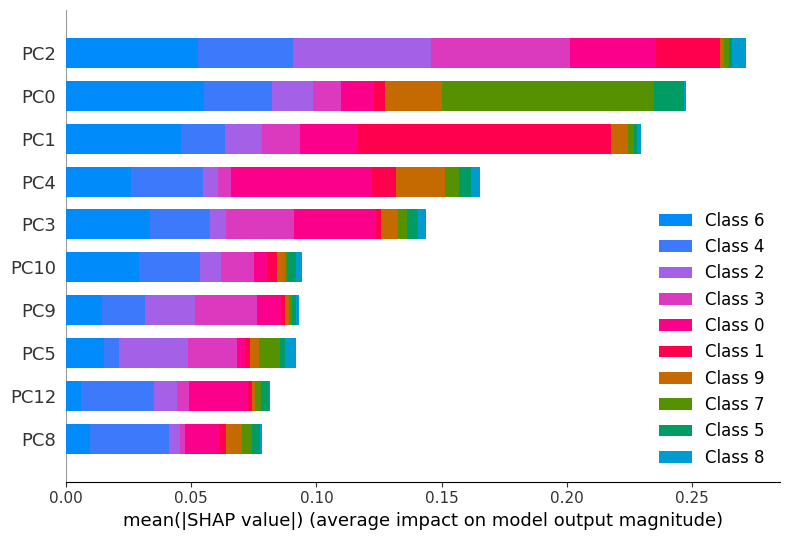

In [11]:
# Obtain the global importance plot
shap.initjs()
shap.summary_plot(shap_values, feature_names = feature_names, max_display = 10)

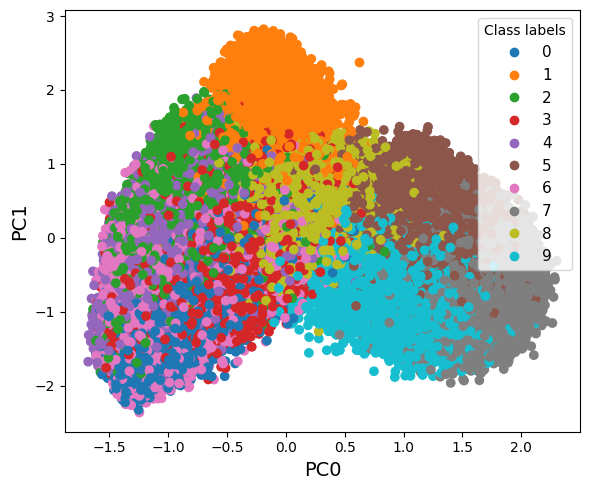

In [12]:
# Plot all data in a 2D feature space regarding the top two globally important features (training data)
_, ax = plt.subplots(figsize = (6,5))
plt.rcParams["image.cmap"] = "tab10"
scatter = ax.scatter(data['train'][0][:,0], data['train'][0][:,2], c=data['train'][1])
plt.xlabel('PC0', fontsize = 14)
plt.ylabel('PC1', fontsize = 14)
_ = ax.legend(
    scatter.legend_elements()[0], np.unique(data['train'][1].astype(int)), title="Class labels", fontsize = 11
)
plt.tight_layout()

True class: 1.0
Predicted class: 1.0
Predicted Probability: [6.78611388e-12 9.99994601e-01 4.63083324e-07 1.65120651e-06
 1.94214792e-07 1.26470823e-08 3.01194771e-06 3.60295025e-08
 1.11132982e-08 1.89855029e-08]


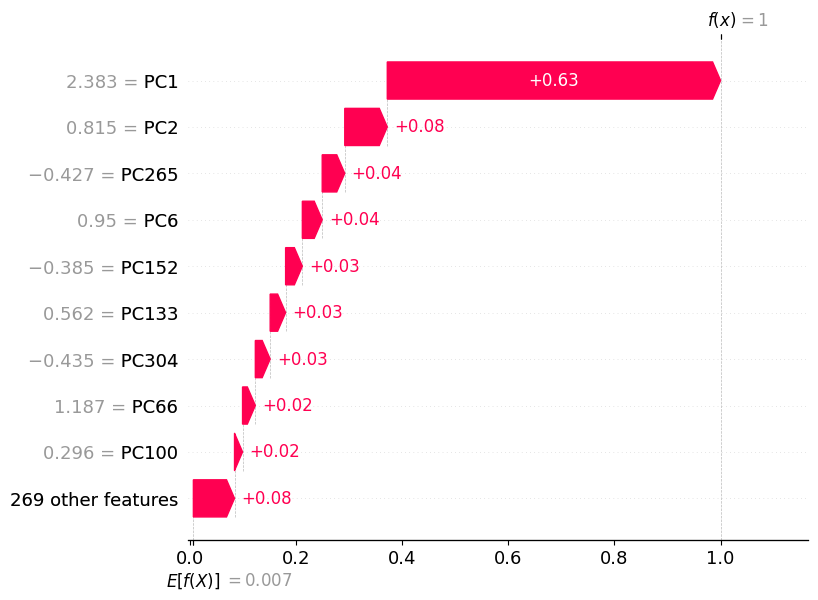

In [14]:
# Obtain individual SHAP explanation
i = 2
print('True class:', y_test[i])
print('Predicted class:', test_preds[i])
print('Predicted Probability:', test_pred_probs[i])
shap.waterfall_plot(shap.Explanation(values=shap_values[int(test_preds[i])][i],
                                              base_values=explainer.expected_value[int(test_preds[i])], data=X_test[i,:],
                                         feature_names=list(feature_names)))